# Importing Libraries

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
import optuna
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Reading data

In [2]:
df = pd.read_csv("Light_Rail_Patronage.csv")
df.head()

,Date,MyWay,Paper Ticket,Total
0,08/01/2021,"7,926",427,"8,353"
1,17/04/2021,"5,438",591,"6,029"
2,09/01/2021,"4,647",391,"5,038"
3,14/09/2020,"8,156",203,"8,359"
4,06/06/2022,"9,751",328,"10,079"


# Data Preprocessing

## Rename columns

In [3]:
df.rename(columns={'Date':'date','MyWay':'my_way','Paper Ticket':'paper_ticket','Total':'total'}, inplace=True)

In [4]:
df.tail()

,date,my_way,paper_ticket,total
1238,14/09/2022,"11,551",391,"11,942"
1239,03/09/2022,"5,942",539,"6,481"
1240,15/09/2022,"10,619",392,"11,011"
1241,16/09/2022,"11,324",524,"11,848"
1242,17/09/2022,"5,918",439,"6,357"


## Removing all special characters, punctuation and spaces

In [5]:
df['my_way'] = df['my_way'].apply(lambda x: ''.join(e for e in x if e.isalnum()))

In [6]:
df['total'] = df['total'].apply(lambda x: ''.join(e for e in x if e.isalnum()))

In [7]:
df['paper_ticket'] = df['paper_ticket'].apply(lambda x: ''.join(e for e in x if e.isalnum()))

In [8]:
df.head()

,date,my_way,paper_ticket,total
0,08/01/2021,7926,427,8353
1,17/04/2021,5438,591,6029
2,09/01/2021,4647,391,5038
3,14/09/2020,8156,203,8359
4,06/06/2022,9751,328,10079


## Changing the datatype

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1243 non-null   object
 1   my_way        1243 non-null   object
 2   paper_ticket  1243 non-null   object
 3   total         1243 non-null   object
dtypes: object(4)
memory usage: 39.0+ KB


In [10]:
df['date']= df['date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))

In [11]:
df['my_way'] = df['my_way'].astype('int')
df['paper_ticket'] = df['paper_ticket'].astype('int')
df['total'] = df['total'].astype('int')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1243 non-null   datetime64[ns]
 1   my_way        1243 non-null   int32         
 2   paper_ticket  1243 non-null   int32         
 3   total         1243 non-null   int32         
dtypes: datetime64[ns](1), int32(3)
memory usage: 24.4 KB


In [13]:
df.head()

,date,my_way,paper_ticket,total
0,2021-01-08,7926,427,8353
1,2021-04-17,5438,591,6029
2,2021-01-09,4647,391,5038
3,2020-09-14,8156,203,8359
4,2022-06-06,9751,328,10079


## Sorting the dataframe by date column

In [14]:
df=df.sort_values(by='date').reset_index()
df.head()

,index,date,my_way,paper_ticket,total
0,464,2019-04-22,4075,1418,5493
1,555,2019-04-23,8134,1018,9152
2,705,2019-04-24,9518,1147,10665
3,985,2019-04-25,4866,1313,6179
4,1025,2019-04-26,9074,1143,10217


## Checking duplicate rows

In [15]:
df.duplicated().sum()

0

## Checking missing rows

In [16]:
df.isnull().sum()

index           0
date            0
my_way          0
paper_ticket    0
total           0
dtype: int64

# Data Exploration 

<AxesSubplot:>

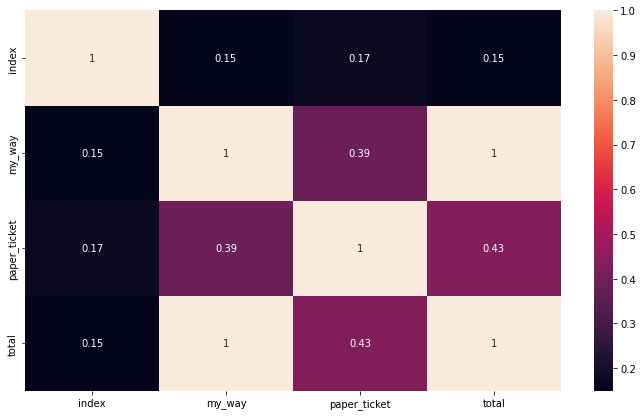

In [17]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True)

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

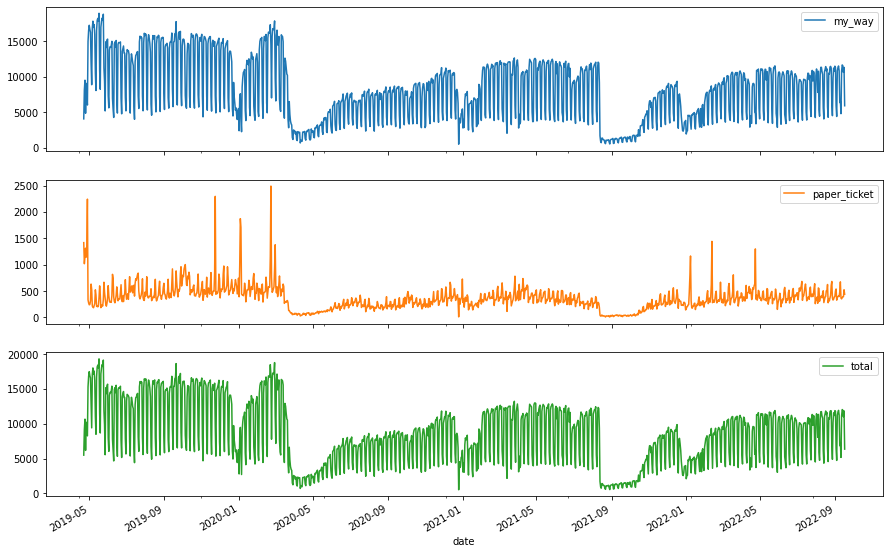

In [18]:
df.set_index('date')[['my_way','paper_ticket','total']].plot(subplots=True,figsize=(15,10))

## Getting day of week, month, year from date column

In [19]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.day_name()

In [20]:
df.head()

,index,date,my_way,paper_ticket,total,month,year,weekday
0,464,2019-04-22,4075,1418,5493,4,2019,Monday
1,555,2019-04-23,8134,1018,9152,4,2019,Tuesday
2,705,2019-04-24,9518,1147,10665,4,2019,Wednesday
3,985,2019-04-25,4866,1313,6179,4,2019,Thursday
4,1025,2019-04-26,9074,1143,10217,4,2019,Friday


## Weekly Boxplot

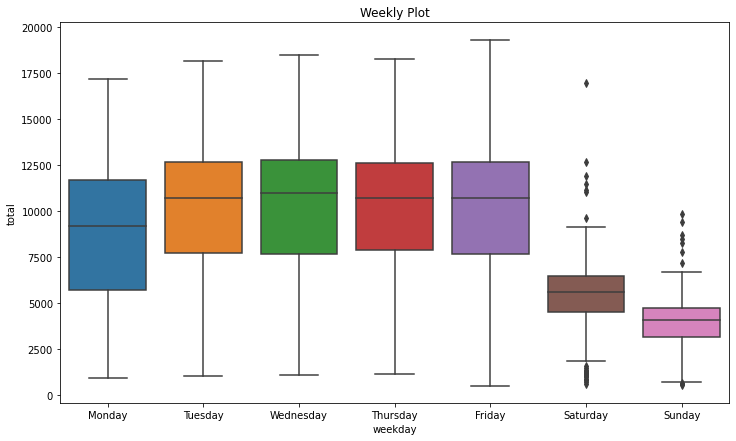

In [21]:
plt.figure(figsize=(12,7))
plot = sns.boxplot(x='weekday', y='total', data=df)
_ = plot.set(title='Weekly Plot')

## Monthly Boxplot

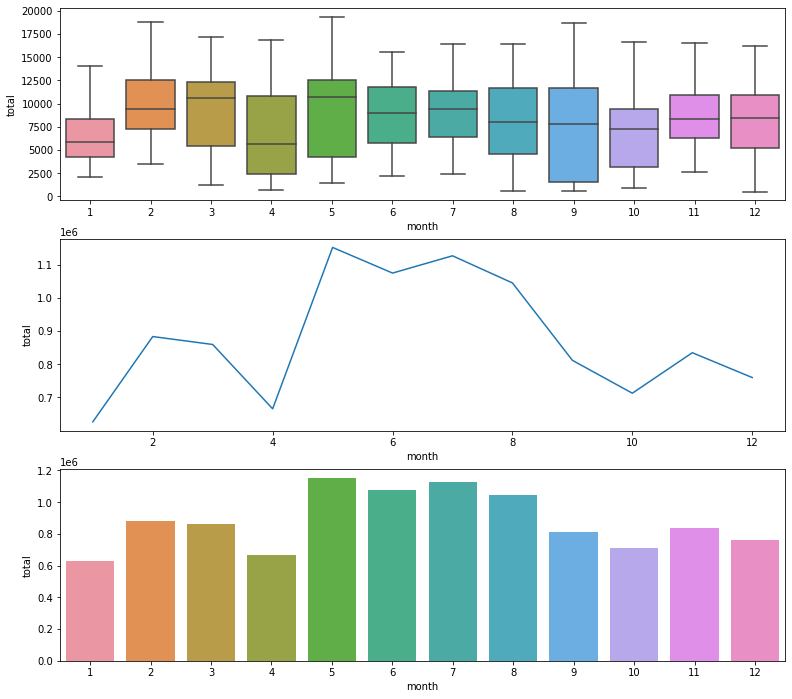

In [22]:
monthly_agg = df.groupby('month',sort=False)['total'].sum().reset_index()
fig, axs = plt.subplots(nrows=3, figsize=(13,12))
sns.boxplot(x='month', y='total', data=df, ax=axs[0])
_ = sns.lineplot(x='month', y='total', data=monthly_agg, ax=axs[1])
_ = sns.barplot(x='month', y='total', data=monthly_agg, ax=axs[2])

## Yearly Boxplot

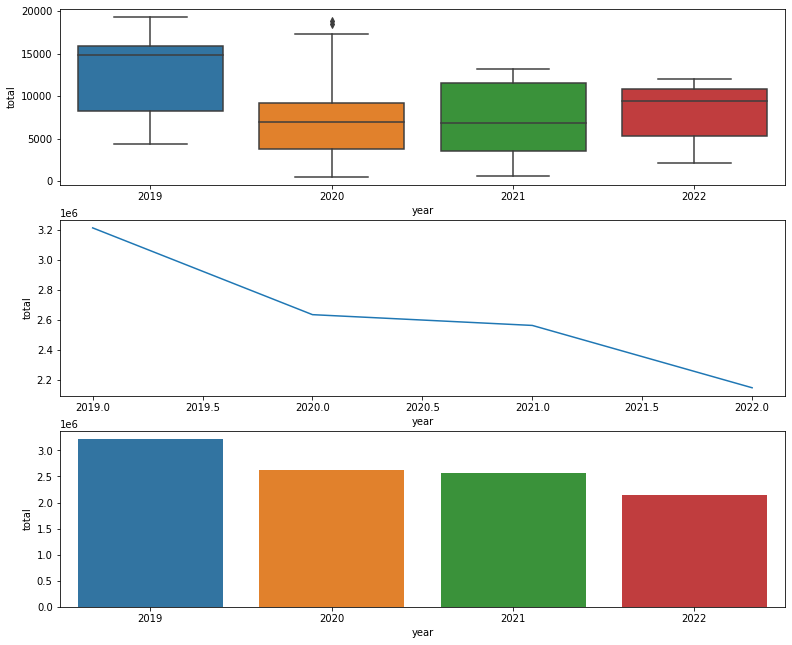

In [23]:
yearly_agg  = df.groupby('year',sort=False)['total'].sum().reset_index()
fig, axs = plt.subplots(nrows=3, figsize=(13,11))
sns.boxplot(x='year', y='total', data=df, ax=axs[0])
_ = sns.lineplot(x='year', y='total', data=yearly_agg , ax=axs[1])
_ = sns.barplot(x='year', y='total', data=yearly_agg, ax=axs[2])

## Plot the time series

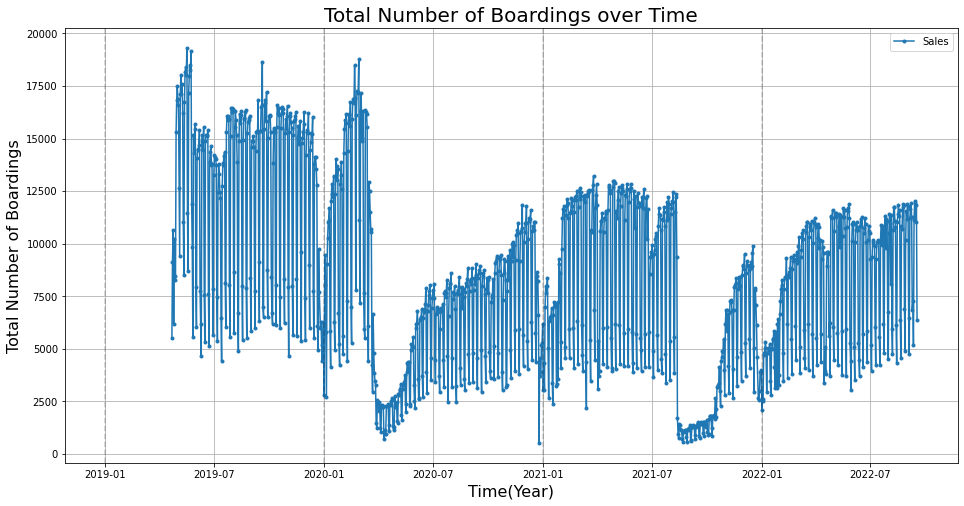

In [24]:
plt.figure(figsize=(16,8))
plt.plot(df['date'],df['total'], ".-", label = 'Sales');
plt.grid()

# plt.figure(figsize=(16,8))

# plt.plot(df['sales'], ".-", label = 'Sales')

plt.title('Total Number of Boardings over Time', fontsize=20)
plt.xlabel("Time(Year)", fontsize=16)
plt.ylabel("Total Number of Boardings", fontsize=16)
plt.legend(loc = 'best')
for year in range(2019,2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Set date as index

In [ ]:
df_orig = df.copy()

In [25]:
df.set_index('date', inplace=True)
df.head()

,index,my_way,paper_ticket,total,month,year,weekday
date,,,,,,,
2019-04-22,464,4075,1418,5493,4,2019,Monday
2019-04-23,555,8134,1018,9152,4,2019,Tuesday
2019-04-24,705,9518,1147,10665,4,2019,Wednesday
2019-04-25,985,4866,1313,6179,4,2019,Thursday
2019-04-26,1025,9074,1143,10217,4,2019,Friday


In [26]:
df.drop('index',axis=1,inplace=True)
df.head()

,my_way,paper_ticket,total,month,year,weekday
date,,,,,,
2019-04-22,4075,1418,5493,4,2019,Monday
2019-04-23,8134,1018,9152,4,2019,Tuesday
2019-04-24,9518,1147,10665,4,2019,Wednesday
2019-04-25,4866,1313,6179,4,2019,Thursday
2019-04-26,9074,1143,10217,4,2019,Friday


## Extracting required columns

In [27]:
df=df[['my_way','paper_ticket','total']]
df.head()

,my_way,paper_ticket,total
date,,,
2019-04-22,4075,1418,5493
2019-04-23,8134,1018,9152
2019-04-24,9518,1147,10665
2019-04-25,4866,1313,6179
2019-04-26,9074,1143,10217


In [28]:
df.tail()

,my_way,paper_ticket,total
date,,,
2022-09-13,11665,375,12040
2022-09-14,11551,391,11942
2022-09-15,10619,392,11011
2022-09-16,11324,524,11848
2022-09-17,5918,439,6357


In [29]:
df.shape

(1243, 3)

### Splitting the data into train and test with all the features

In [30]:
train_end = datetime(2022,6,16) #2022-06-16
test_end = datetime(2022,9,17) #2022-09-17

train_df = df[:train_end]
test_df = df[train_end + timedelta(days=1):test_end]

In [31]:
train_lr = train_df.copy()
test_lr = test_df.copy()

In [32]:
train_lr.head()

,my_way,paper_ticket,total
date,,,
2019-04-22,4075,1418,5493
2019-04-23,8134,1018,9152
2019-04-24,9518,1147,10665
2019-04-25,4866,1313,6179
2019-04-26,9074,1143,10217


In [33]:
test_lr.head()

,my_way,paper_ticket,total
date,,,
2022-06-17,10818,470,11288
2022-06-18,5183,516,5699
2022-06-19,3845,273,4118
2022-06-20,10128,377,10505
2022-06-21,10418,323,10741


In [34]:
X_train = train_lr.drop('total',axis=1)
y_train = train_lr['total']
X_test = test_lr.drop('total',axis=1)
y_test = test_lr['total']

In [35]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1150, 2) (1150,)
(93, 2) (93,)


In [36]:
X_train.head()

,my_way,paper_ticket
date,,
2019-04-22,4075,1418
2019-04-23,8134,1018
2019-04-24,9518,1147
2019-04-25,4866,1313
2019-04-26,9074,1143


# Model Building

In [91]:
QUANTILES = [0.1, 0.5, 0.9]
# QUANTILES.reverse()  # Test out to see if we're getting different results.

In [66]:
df_copy = df.reset_index()
df_copy.head()

,date,my_way,paper_ticket,total,Pred_RF
0,2019-04-22,4075,1418,5493,0
1,2019-04-23,8134,1018,9152,0
2,2019-04-24,9518,1147,10665,0
3,2019-04-25,4866,1313,6179,0
4,2019-04-26,9074,1143,10217,0


## Random Forest Model

In [56]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [57]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1)

In [63]:
 np.concatenate([rf_quantile(rf, X_test, q) for q in QUANTILES]) 

array([11206. ,  5636. ,  4068. , 10484. , 10671. , 11206. , 10929. ,
        9888.3,  5782. ,  4333. , 10076. , 10770. , 10578.4, 10402. ,
        9045. ,  5100.4,  3895. ,  9215. ,  9889. ,  9889. ,  9736. ,
        9593. ,  5971. ,  4207. ,  9215. ,  9943.6,  9889. ,  9889. ,
        9822. ,  5481. ,  4191. , 10076. , 10833. , 10782. ,  9882.3,
       10599. ,  6075. ,  4734. , 10843. , 11238.7,  9707. , 11113. ,
       10966. ,  6413. ,  4418. , 10492. , 11403. , 10954. ,  8000. ,
       11225. ,  5831. ,  4709. , 10561. , 11685. , 11685. , 11048. ,
       10636.8,  6034. ,  4284. , 10939. , 11263. , 11730. , 11206. ,
       11447. ,  6274. ,  4436.9, 10833. , 10671. , 11676. , 11771. ,
       11614.8,  6472.9,  4783. , 10206. , 11556. , 11175. , 11750. ,
       11763.7,  6159. ,  4680. , 11206. , 11577. , 11826. , 11206. ,
        6638. ,  6840. ,  5000. , 11048. , 11930. , 11899. , 10955. ,
       11771. ,  6143. , 11239. ,  5690. ,  4106. , 10492. , 10770. ,
       11221. , 1095

In [79]:
#pred_rf1,pred_rf2,pred_rf3 = [rf_quantile(rf, X_test, q) for q in QUANTILES]

In [80]:
#len(pred_rf1),len(pred_rf2),len(pred_rf3)

(93, 93, 93)

In [82]:
pred_rf1,pred_rf2,pred_rf3 = [rf_quantile(rf, X_test, q) for q in QUANTILES]
df_pred_rf = pd.DataFrame(pred_rf1)
df_pred_rf.rename(columns={0:'pred_rf1'},inplace=True)
df_pred_rf['pred_rf2'] = pred_rf2
df_pred_rf['pred_rf3'] = pred_rf3
df_pred_rf.head()

,pred_rf1,pred_rf2,pred_rf3
0,11206.0,11239.0,11372.0
1,5636.0,5690.0,5714.0
2,4068.0,4106.0,4141.0
3,10484.0,10492.0,10580.0
4,10671.0,10770.0,10782.0


In [85]:
for i,row in df_pred_rf.iterrows():
        df_copy.loc[i,'Pred_RF_P10'] = row['pred_rf1']
        df_copy.loc[i,'Pred_RF_P50'] = row['pred_rf2']
        df_copy.loc[i,'Pred_RF_p90'] = row['pred_rf3']
df_copy.head()

,date,my_way,paper_ticket,total,Pred_RF_P10,Pred_RF_P50,Pred_RF_p90
0,2019-04-22,4075,1418,5493,11206.0,11239.0,11372.0
1,2019-04-23,8134,1018,9152,5636.0,5690.0,5714.0
2,2019-04-24,9518,1147,10665,4068.0,4106.0,4141.0
3,2019-04-25,4866,1313,6179,10484.0,10492.0,10580.0
4,2019-04-26,9074,1143,10217,10671.0,10770.0,10782.0


## Gradient Boosting Model

In [197]:
gb = GradientBoostingRegressor(loss='quantile')
gb

GradientBoostingRegressor(loss='quantile')

In [196]:
def gb_quantile(X_train, train_labels, X, q):
    gbf = GradientBoostingRegressor(loss='quantile', alpha=q)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)

In [106]:
pred_gb1,pred_gb2,pred_gb3 = [gb_quantile(X_train, y_train, X_test, q) for q in QUANTILES]
df_pred_gb = pd.DataFrame(pred_gb1)
df_pred_gb.rename(columns={0:'pred_gb1'},inplace=True)
df_pred_gb['pred_gf2'] = pred_gb2
df_pred_gb['pred_gf3'] = pred_gb3
df_pred_gb.head()

,pred_gb1,pred_gf2,pred_gf3
0,10709.742131,11194.495828,11458.030925
1,5607.634420,5562.008618,5669.181516
2,3941.287710,4113.563281,4816.590830
3,8495.589131,10555.346584,10632.223477
4,8469.731103,10773.978203,10734.341494


In [108]:
for i,row in df_pred_gb.iterrows():
        df_copy.loc[i,'Pred_GB_P10'] = row['pred_gb1']
        df_copy.loc[i,'Pred_GB_P50'] = row['pred_gf2']
        df_copy.loc[i,'Pred_GB_p90'] = row['pred_gf3']
df_copy.head()

,date,my_way,paper_ticket,total,Pred_RF_P10,Pred_RF_P50,Pred_RF_p90,Pred_GB_P10,Pred_GB_P50,Pred_GB_p90
0,2019-04-22,4075,1418,5493,11206.0,11239.0,11372.0,10709.742131,11194.495828,11458.030925
1,2019-04-23,8134,1018,9152,5636.0,5690.0,5714.0,5607.634420,5562.008618,5669.181516
2,2019-04-24,9518,1147,10665,4068.0,4106.0,4141.0,3941.287710,4113.563281,4816.590830
3,2019-04-25,4866,1313,6179,10484.0,10492.0,10580.0,8495.589131,10555.346584,10632.223477
4,2019-04-26,9074,1143,10217,10671.0,10770.0,10782.0,8469.731103,10773.978203,10734.341494


In [124]:
len(df_copy)

1243

## Calculate Quantile Loss

In [109]:
# pandas version rather than Keras.
def quantile_loss(q, y, f):
    # q: Quantile to be evaluated, e.g., 0.5 for median.
    # y: True value.
    # f: Fitted or predicted value.
    e = y - f
    return np.maximum(q * e, (q - 1) * e)

In [125]:
quantile_loss_rf_p10 = quantile_loss(0.10,df_copy['total'],df_copy['Pred_RF_P10'])
quantile_loss_rf_p50 = quantile_loss(0.50,df_copy['total'],df_copy['Pred_RF_P50'])
quantile_loss_rf_p90 = quantile_loss(0.90,df_copy['total'],df_copy['Pred_RF_p90'])

In [126]:
quantile_loss_gb_p10 = quantile_loss(0.10,df_copy['total'],df_copy['Pred_GB_P10'])
quantile_loss_gb_p50 = quantile_loss(0.50,df_copy['total'],df_copy['Pred_GB_P50'])
quantile_loss_gb_p90 = quantile_loss(0.90,df_copy['total'],df_copy['Pred_GB_p90'])

In [127]:
len(quantile_loss_gb_p10)

1243

In [132]:
quantile_loss_rf_p10

0       5141.7
1        351.6
2        659.7
3       3874.5
4        408.6
         ...  
1238       NaN
1239       NaN
1240       NaN
1241       NaN
1242       NaN
Length: 1243, dtype: float64

In [128]:
pd.concat([quantile_loss_rf_p10,quantile_loss_rf_p50,quantile_loss_rf_p90])

0       5141.7
1        351.6
2        659.7
3       3874.5
4        408.6
         ...  
1238       NaN
1239       NaN
1240       NaN
1241       NaN
1242       NaN
Length: 3729, dtype: float64

In [142]:
pred_quantile_losses = pd.concat([df_copy['total'],quantile_loss_rf_p10,quantile_loss_rf_p50,quantile_loss_rf_p90,quantile_loss_gb_p10,quantile_loss_gb_p50,quantile_loss_gb_p90],axis=1)
pred_quantile_losses.rename(columns={0:'quantile_loss_rf_p10',1:'quantile_loss_rf_p50',2:'quantile_loss_rf_p90',3:'quantile_loss_gb_p10',4:'quantile_loss_gb_p50',5:'quantile_loss_gb_p90'},inplace=True)

In [143]:
pred_quantile_losses.head()

,total,quantile_loss_rf_p10,quantile_loss_rf_p50,quantile_loss_rf_p90,quantile_loss_gb_p10,quantile_loss_gb_p50,quantile_loss_gb_p90
0,5493,5141.7,2873.0,587.9,4695.067918,2850.747914,596.503093
1,9152,351.6,1731.0,3094.2,354.436558,1794.995691,3134.536635
2,10665,659.7,3279.5,5871.6,672.371229,3275.718360,5263.568253
3,6179,3874.5,2156.5,440.1,2084.930218,2188.173292,445.322348
4,10217,408.6,276.5,56.5,174.726890,278.489102,51.734149


In [144]:
pred_quantile_losses.isnull().sum()

total                      0
quantile_loss_rf_p10    1150
quantile_loss_rf_p50    1150
quantile_loss_rf_p90    1150
quantile_loss_gb_p10    1150
quantile_loss_gb_p50    1150
quantile_loss_gb_p90    1150
dtype: int64

In [145]:
pred_quantile_losses.shape

(1243, 7)

In [157]:
pred_quantile_losses[~pred_quantile_losses['quantile_loss_rf_p10'].isna()]

,total,quantile_loss_rf_p10,quantile_loss_rf_p50,quantile_loss_rf_p90,quantile_loss_gb_p10,quantile_loss_gb_p50,quantile_loss_gb_p90
0,5493,5141.7,2873.0,587.90,4695.067918,2850.747914,596.503093
1,9152,351.6,1731.0,3094.20,354.436558,1794.995691,3134.536635
2,10665,659.7,3279.5,5871.60,672.371229,3275.718360,5263.568253
3,6179,3874.5,2156.5,440.10,2084.930218,2188.173292,445.322348
4,10217,408.6,276.5,56.50,174.726890,278.489102,51.734149
...,...,...,...,...,...,...,...
88,14360,243.0,1131.0,2017.26,234.931128,1159.709600,1975.538419
89,8145,3378.6,1884.5,389.36,3355.264592,1947.790400,372.092705
90,6034,4428.9,2496.5,499.70,2898.800218,2543.458672,502.295410
91,15294,352.3,1732.0,3097.80,344.076574,1758.906113,3060.623905


In [163]:
overall_loss_comparison = pred_quantile_losses[~pred_quantile_losses['quantile_loss_rf_p10'].isnull()].sort_values('total').reset_index()
overall_loss_comparison

,index,total,quantile_loss_rf_p10,quantile_loss_rf_p50,quantile_loss_rf_p90,quantile_loss_gb_p10,quantile_loss_gb_p50,quantile_loss_gb_p90
0,83,4416,6111.00,3402.50,682.30,5527.477918,3363.482058,700.305047
1,49,4662,5906.70,3307.50,677.80,4867.543682,3297.686461,681.633370
2,62,5158,5443.20,3059.50,621.40,4996.567918,3025.633233,630.003093
3,55,5327,5148.90,2907.75,590.93,4151.483218,2907.982058,597.498095
4,76,5371,5741.10,3227.50,654.30,5777.743091,3165.559456,648.612705
...,...,...,...,...,...,...,...,...
88,31,18251,817.50,4082.50,7279.20,975.541087,3975.851413,6979.976112
89,23,18417,1421.00,7095.50,12771.90,1425.572253,7150.267430,12240.368253
90,30,18490,1429.90,7130.00,12798.90,1433.130122,7186.767430,12306.068253
91,32,19144,831.10,4150.50,7371.00,988.911087,4185.010898,7286.775606


In [177]:
pred_quantile_loss_rf_p10 = sum(overall_loss_comparison['quantile_loss_rf_p10'])
pred_quantile_loss_rf_p50 = sum(overall_loss_comparison['quantile_loss_rf_p50'])
pred_quantile_loss_rf_p90 = sum(overall_loss_comparison['quantile_loss_rf_p90'])
pred_quantile_loss_rf = [pred_quantile_loss_rf_p10,pred_quantile_loss_rf_p50,pred_quantile_loss_rf_p90]
pred_quantile_loss_rf

[137161.62000000005, 268698.75, 393109.7400000001]

In [180]:
pred_quantile_loss_gb_p10 = sum(overall_loss_comparison['quantile_loss_gb_p10'])
pred_quantile_loss_gb_p50 = sum(overall_loss_comparison['quantile_loss_gb_p50'])
pred_quantile_loss_gb_p90 = sum(overall_loss_comparison['quantile_loss_gb_p90'])
pred_quantile_loss_gb = [pred_quantile_loss_gb_p10,pred_quantile_loss_gb_p50,pred_quantile_loss_gb_p90]
pred_quantile_loss_gb

[123437.12364223276, 268145.26463089866, 388215.14614026423]

In [183]:
pred_q_l = pd.DataFrame(pred_quantile_loss_rf,index=QUANTILES).rename(columns={0:'pred_quantile_loss_rf'})
pred_q_l['pred_quantile_loss_gb'] = pred_quantile_loss_gb
pred_q_l

,pred_quantile_loss_rf,pred_quantile_loss_gb
0.1,137161.62,123437.123642
0.5,268698.75,268145.264631
0.9,393109.74,388215.146140


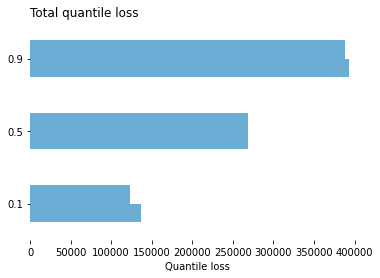

In [191]:
with sns.color_palette('Blues', 1):
    ax = pred_q_l.plot.barh()
    plt.title('Total quantile loss', loc='left')
    sns.despine(left=True, bottom=True)
    plt.xlabel('Quantile loss')
    plt.ylabel('')
    ax.legend_.remove()

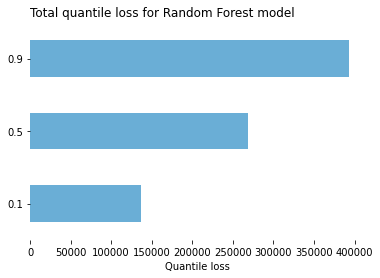

In [198]:
with sns.color_palette('Blues', 1):
    ax = pred_q_l['pred_quantile_loss_rf'].plot.barh()
    plt.title('Total quantile loss for Random Forest model', loc='left')
    sns.despine(left=True, bottom=True)
    plt.xlabel('Quantile loss')
    plt.ylabel('')
#     ax.legend_.remove()

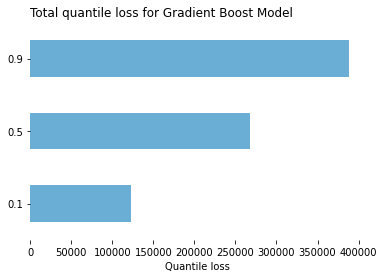

In [199]:
with sns.color_palette('Blues', 1):
    ax = pred_q_l['pred_quantile_loss_gb'].plot.barh()
    plt.title('Total quantile loss for Gradient Boost Model', loc='left')
    sns.despine(left=True, bottom=True)
    plt.xlabel('Quantile loss')
    plt.ylabel('')
#     ax.legend_.remove()